# Ejemplo de tarea resuelta

## Preparación del ambiente de computación

Para poder ejecutar los análisis de este cuaderno es necesario:

1. Instalar BLAST.
2. Descomprimir el archivo taxdb.btd.gz

Para hacerlo de forma automática desde R, disponemos en esta carpeta del pequeño *script* de BASH: `preparar_ambiente.sh`. Esta vez, sólo hace falta ejecutar el bloque siguiente, sin necesidad de salir del cuaderno:

In [2]:
system2(command = './preparar_ambiente.sh', wait = TRUE)

## Introducción
El SARS-CoV-2 es un betacoronavirus descubierto en china a finales de 2019 que infecta principalmente a humanos. El mecanismo de entrada a las células lo realiza a través de su glicoproteina espicular ('spike protein') o proteina S, la cual está formada por dos subunidades: la subunidad 1 S1 que contiene el dominio de unión a ribosa y es el encargado de reconocer la proteina de membrana ACE2, y la subunidad S2,que media la entrada mediante la fusión de membrana.(1)
El objetivo de este análisis es explorar la distribución taxonómica de las secuencias homólogas a la de la proteina S del SARS-CoV2.

## Métodos
La base de datos de secuencias en la que voy a buscar homologías és Swissprot, porque es una base de datos de proteínas ya instalada localmente en este ambiente.

Uilizaré **blastp** (Altschul *et al.*, 1990) con diferentes umbrales de valor E, para determinar a qué ritmo aumenta la distribución taxonómica de las secuencias encontradas a medida que se relaja el grado de similitud exigido. Es decir, a medida que acepto como resultados del **blastp** secuencias con un valor E mayor. 
En este caso, al tratarse de una proteína de gran tamaño (>1300 aa) los valores E deberán ser más grandes.

## Resultados
### BLASTP individual
Primero, ejecuto una única búsqueda con **blastp**, usando un umbral de valor E de 1.0e-50, que es muy exigente: sólo las secuencias extremadamente parecidas a la original apareceran en los resultados.

In [4]:
# Observa entre los argumentes la especificación del formato de salida,
# "-outfmt". Si hace falta, desliza la barra para visualizar la línea completa.
BlastpOut01 <- system2(command = 'blastp',
                      args = c('-db', 'swissprot',
                              '-query', 'protein.faa',
                              '-evalue', '1.0e-50',
                              '-outfmt', '"7 saccver pident length qstart qend sstart send evalue staxid ssciname sblastname"'),
                      stdout = TRUE)

# El resultado del comando anterior, guardado en "BlastOut01", es un montón de
# texto plano. Con las funciones textConnection() y read.table(), lo transformamos
# en un "data frame", una tabla donde cada columna es una variable. La opción
# "col.names" en read.table() sirve para dar nombre a las columnas.
TablaOut01 <- read.table(textConnection(BlastpOut01),
                        sep = '\t',
                        col.names = c('saccver', 'pident', 'length', 'qstart',
                                     'qend', 'sstart', 'send', 'evalue', 'staxid',
                                     'ssciname', 'sblastname'))
# Dimensiones de la tabla:
dim(TablaOut01)

[1] 50 11

In [5]:
head(TablaOut01)

,saccver,pident,length,qstart,qend,sstart,send,evalue,staxid,ssciname,sblastname
,<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<fct>,<fct>
1,P0DTC2.1,100.000,1273,1,1273,1,1273,0,2697049,Severe acute respiratory syndrome coronavirus 2,viruses
2,P59594.1,76.038,1277,1,1273,1,1255,0,694009,Severe acute respiratory syndrome-related coronavirus,viruses
3,Q3LZX1.1,76.041,1273,1,1273,5,1242,0,442736,Bat SARS coronavirus HKU3,viruses
4,Q3I5J5.1,75.334,1273,1,1273,5,1241,0,349344,Bat SARS CoV Rp3/2004,viruses
5,Q0Q475.1,74.745,1275,1,1273,3,1241,0,389167,Bat CoV 279/2005,viruses
6,A3EXG6.1,32.659,1286,36,1266,45,1267,0,694006,Rousettus bat coronavirus HKU9,viruses


La tabla de resultados incluye 50 secuencias encontradas, incluyendo la misma secuencia usada como *query*. Las columnas de la tabla són:

- **saccver**: número de acceso o identificador de la secuencia encontrada (*subject*).
- **pident**: porcentaje de identidad entre la *query* y el *subject* en su alineamiento local.
- **length**: longitud del alineamiento entre *query* y *subject*.
- **qstart**: primera posición de la *query* alineada.
- **qend**: última posición alineada en la *query*.
- **sstart**: primera posición de la *subject* alineada.
- **send**: última posición de la *subject* alineada.
- **evalue**: valor E del alineamiento. Es decir, número de alineamientos de igual o mejor puntuación esperados por azar en una base de datos igual de grande.
- **staxid**: identificador de la especie a la que pertenece la *subject*, en la base de datos de taxonomía del NCBI.
- **ssciname**: nombre científico de la especie a la que pertenece la *subject*.
- **sblastname**: nombre de un grupo taxonómico de rango superior al que pertenece la *subject*, usado para facilitar la interpretación.

Ya se puede observar como, con un E-valor relativamente pequeño como es e-50 encontramos un gran numero de secuencias. De ellas las 5 primeras presentan porcentajes de identidad mayores a 70 mientras que el resto está alrededor de 35. Esto nos servirá mas adelante para obtener conclusiones.

### BLASTP en serie
Para ver cómo aumenta el número de secuencias a medida que aumenta el umbral de valor E, deberíamos repetir la búsqueda unas cuantas veces, con valores del parámetro `-evalue` diferentes. Podemos hacerlo de forma automática, por ejemplo, usando la función `lapply()`. El código siguiente ejecutará una búsqueda de **blastp** para cada valor del vector `Valores_E_maximos`. El resultado será una lista de tablas, como la anterior. 
Utilizaremos valores de E muy pequeños debido a que para secuencias muy grandes y muy similares el valor E tiene a hacerse pequeño.

In [6]:
Valores_E_maximos <- c('1.0e-200', '1.0e-140', '1.0e-130', '1.0e-120', '1.0e-110',
                       '1.0e-90', '1.0e-70', '1.0e-30', '1.0e-10', '1')

# La función lapply() aplicará una función (segundo argumento) sobre
# cada uno de los valores de la lista o vector indicados en el primer
# argumento (Valores_E_maximos, en este caso). La función que aplicamos
# la definimos entre llaves ("{}"). Incluye todos los pasos necesarios
# para obtener una tabla de resultados como la anterior.
Lista_de_Tablas <- lapply(Valores_E_maximos,
                          function(x) {
                              BlastpOut <- system2(
                                  command = 'blastp',
                                  args = c('-db', 'swissprot',
                                           '-query', 'protein.faa',
                                           '-evalue', x,
                                           '-outfmt',
                                           '"7 saccver pident length qstart qend sstart send evalue staxid ssciname sblastname"'),
                                  stdout = TRUE)
                              read.table(textConnection(BlastpOut),
                                         sep = '\t',
                                         col.names = c('saccver', 'pident', 'length', 'qstart',
                                            'qend', 'sstart', 'send', 'evalue', 'staxid',
                                            'ssciname', 'sblastname'))
                          })

El objeto `Lista_de_Tablas` guarda las tablas de resultados de los diez **blastp** ejecutados. Podemos acceder a una tabla individual mediante los dobles corchetes:

In [13]:
tails(Lista_de_Tablas[[9]])

saccver,pident,length,qstart,qend,sstart,send,evalue,staxid,ssciname,sblastname
<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<fct>,<fct>
P0DTC2.1,100.000,1273,1,1273,1,1273,0.00e+00,2697049,Severe acute respiratory syndrome coronavirus 2,viruses
P59594.1,76.038,1277,1,1273,1,1255,0.00e+00,694009,Severe acute respiratory syndrome-related coronavirus,viruses
Q3LZX1.1,76.041,1273,1,1273,5,1242,0.00e+00,442736,Bat SARS coronavirus HKU3,viruses
Q3I5J5.1,75.334,1273,1,1273,5,1241,0.00e+00,349344,Bat SARS CoV Rp3/2004,viruses
Q0Q475.1,74.745,1275,1,1273,3,1241,0.00e+00,389167,Bat CoV 279/2005,viruses
A3EXG6.1,32.659,1286,36,1266,45,1267,0.00e+00,694006,Rousettus bat coronavirus HKU9,viruses
A3EXD0.1,37.113,1067,246,1264,306,1349,0.00e+00,694008,Pipistrellus bat coronavirus HKU5,viruses
Q0Q4F2.1,36.314,1096,232,1264,280,1347,4.17e-180,389230,Bat coronavirus (BtCoV/133/2005),viruses
K9N5Q8.1,35.194,1057,263,1263,311,1347,1.05e-173,1263720,Betacoronavirus England 1,viruses


Para saber cuántas secuencias homólogas ha encontrado **blastp** en la base de datos con cada valor del parámetro `-evalue`, aplico la función `dim()` que devuelve las dimensiones del objeto en cuestión (número de filas y de columnas) y me quedo con la primera dimensión (número de filas):

In [4]:
#sapply() aplica la funció lapply y estudia la salida. 
#Cuando entiende que dicha salida admite una representación menos aparatosa que una lista, la simplifica.
#En este caso presenta la longitud dim(x) de las filas 
Numero_de_resultados <- sapply(Lista_de_Tablas, function(x) dim(x)[1])
Numero_de_resultados

[1]  5 10 29 31 31 48 50 50 71 76

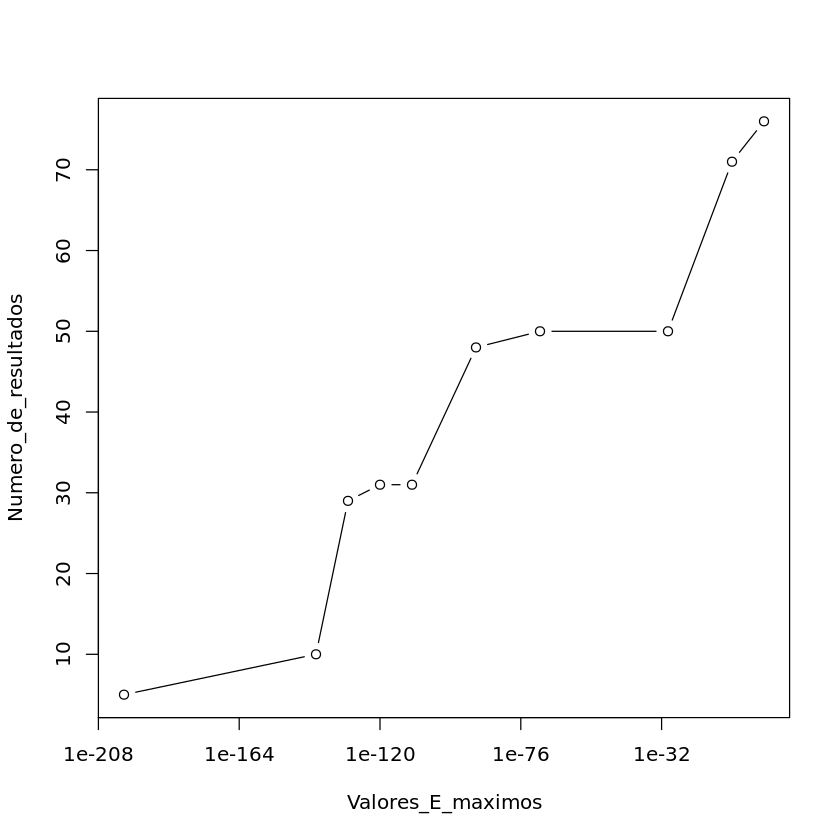

In [5]:
# En la representación gráfica, podemos usar escala logarítmica solamente
# en un eje ("log='x'"), en los dos, o en ninguno.
plot(Valores_E_maximos, Numero_de_resultados, log = 'x', type = 'b')

A continuación examino la relación entre la longitud del alineamiento y el valor E de los resultados guardados en la última tabla, la número 10, en la que he usado un valor E de 1 y que contiene un mayor número de resultados.

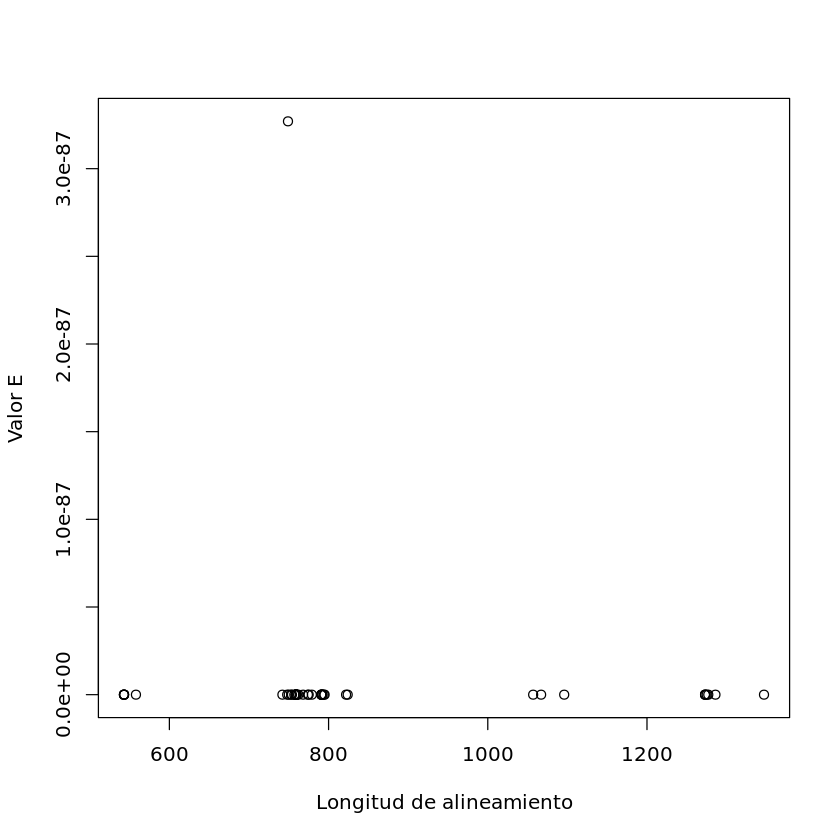

In [10]:
# El símbolo "$" extrae de un "data frame" una columna. Si ejecutas
# "Lista_de_Tablas[[3]]$length", verás que el resultado es el vector
# de las longitudes de los alineamientos de la tercera tabla, por ejemplo.
plot(Lista_de_Tablas[[10]]$length, Lista_de_Tablas[[10]]$evalue,
     xlab = 'Longitud de alineamiento', ylab = 'Valor E')

La Spike protein tiene un tamaño de 1300 aminoacidos sin embargo se observan algunas secuencias con alto valor E y poca longitud de alineamiento, mientras que otras presentan un alto valor E pero también poca longitud de alineamiento. Esto indica que existen algunas proteínas en la base de datos que presentan homología **parcial**. Es decir, que algunos de estos resultados corresponden a proteínas que solo se parecen a la proteina S en un fragmento concreto; probablemente un dominio de función conservada y posiblemente se encuentre en el dominio S2 transmembrana. Cabe preguntar qué posiciones de la proteina S son esas que participan en los alineamientos parciales. 

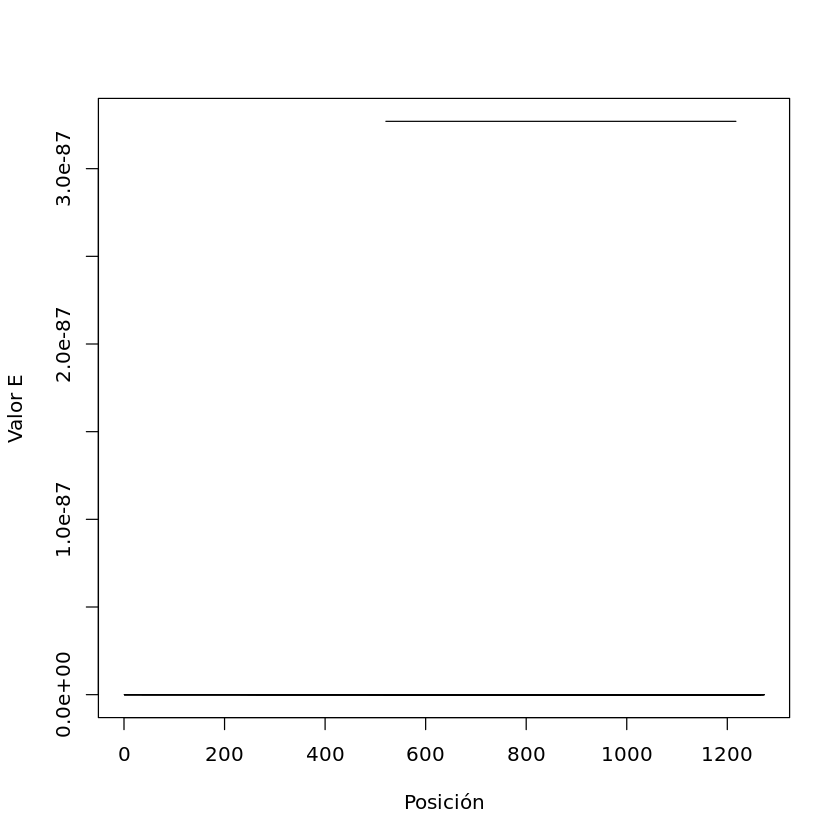

In [12]:
inicios <- Lista_de_Tablas[[7]]$qstart
finales <- Lista_de_Tablas[[7]]$qend
valoresE <- Lista_de_Tablas[[7]]$evalue

# La función segments() añade segmentos a un gráfico previo. Por eso, represento
# antes un gráfico con los rangos adecuados, pero vacío (type='n'). Para determinar
# el rango del eje horizontal, determino primero el valor máximo de "qend".
AlineamientoMaximo <- max(Lista_de_Tablas[[5]]$qend)
plot(c(0, AlineamientoMaximo), range(valoresE), type='n', xlab='Posición', ylab='Valor E')
segments(inicios, valoresE, finales, valoresE)

Esta gráfica muestra que la homología encontrada con valores E mayores no está distribuída aleatoriamente a lo largo de la secuencia de LPOR, sino que, efectivamente, se concentra entre las posiciones 900 y 1000, aproximadamente.

Por último, voy a explorar la distribución taxonómica de las secuencias encontradas. La columna `sblastname` ofrece una clasificación fácilmente interpretable de las secuencias. Una posibilidad es contar en cada tabla las secuencias encontradas de cada grupo taxonómico. Para ello, aplico la función `table()` a esa columna de cada tabla en `Lista_de_Tablas`:

In [9]:
lapply(Lista_de_Tablas, function(x) table(x$sblastname))

[[1]]

viruses 
      5 

[[2]]

viruses 
     10 

[[3]]

viruses 
     29 

[[4]]

viruses 
     31 

[[5]]

viruses 
     31 

[[6]]

viruses 
     48 

[[7]]

viruses 
     50 

[[8]]

viruses 
     50 

[[9]]

viruses 
     71 

[[10]]

      firmicutes g-proteobacteria          viruses 
               4                1               71 


El resultado del código anterior es una lista de recuentos de los diferentes grupos taxonómicos presentes en cada tabla de resultados de **blastp**. En este caso la columna `sblastname` no resulta muy informativa ya que todos los grupos pertenecen a virus, tal y como cabría esperar. Sin embargo en el valor E de 1 ya aparecen grupos bacterianos pertenecientes a los firmicutes y proteobacterias

Puesto que la proteina espicular es únicamente vírica, cabe suponer que solo las proteínas homólogas con valores E menores y con alineamientos más completos conservan la misma función. Para ver la relación entre la longitud del alineamiento y la distribución taxonómica, a continuación repito el recuento de grupos taxonómicos pero contando solamente las secuencias con un alineamiento de al menos 800 aminoácidos:

In [1]:
lapply(Lista_de_Tablas[[8]], function(x) {
       filtro <- x$length >= 800
       table(x[filtro, 'sblastname'])
    }
)

ERROR: Error in lapply(Lista_de_Tablas[[8]], function(x) {: object 'Lista_de_Tablas' not found


## Discusión
Al utilizar la secuencia de la proteína espicular del coronavirus SARS-CoV-2 como query encontramos principalmente proteinas víricas que presentan homología, la mayoría de ellas pertenecientes a otros coronavirus tales como el SARS-CoV u otros coronavirus de murciélagos y roedores(2). Conociendo que esta proteína es la principal responsable de la entrada a la célula y, por tanto, de la especificidad en la infección.
La longitud de aproximadamente 1300 aminoacidos hace que algunas proteinas viricas muestren una homologia parcial con algun fragmento de la proteina espicular, como ya se ha mencionado anteriormente, esta proteina esta formada por dos subunidades, la primera abarca hasta el aminoacido 561 y la segunda es parte del dominio transmembrana que abarca desde la posición 600 hasta el final de la proteina(1). Esto coincide con los alineamientos parciales encontrados, donde podemos observar, por ejemmplo en la tabla de valores 7, correspondiente a un valor E(10E-70) que hay una alta homologia con la mitad correspondiente a la subunidad 2, esto encaja con lo esperado ya que es en la subunidad 1 donde se espera mayor evolucion con respecto a otros linajes o familias de virus ya que es en esta donde se encuentra el dominio de unión a la ribosa encargado de el anclaje al ACE2 del animal.

Para concluir sería recomendable realizar una filogenia mediante el programa informático MEGA X: Molecular Evolutionary Genetics Analysis across computing platforms (Kumar, Stecher, Li, Knyaz, and Tamura 2018) para construir un arbol a partir de las homologias obtenidas.

## Referencias
- (1) Huang, Y., Yang, C., Xu, Xf. et al. Structural and functional properties of SARS-CoV-2 spike protein: potential antivirus drug development for COVID-19. Acta Pharmacol Sin 41, 1141–1149 (2020). https://doi.org/10.1038/s41401-020-0485-4
- (2) Alexandra C. Walls, Young-Jun Park, M. Alejandra Tortorici, Abigail Wall, Andrew T. McGuire, David Veesler,Structure, Function, and Antigenicity of the SARS-CoV-2 Spike Glycoprotein,Cell,Volume 181, Issue 2,2020,Pages 281-292.e6,ISSN 0092-8674,https://doi.org/10.1016/j.cell.2020.02.058.